# Preprocess

In [4]:
from google.colab import drive

import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [106]:
import zipfile
import os

# URL of the zip file
zip_url = "https://github.com/billowdev/get-dominant-color/raw/refs/heads/main/charts.zip"  # Replace with the actual URL

# Download the zip file using wget
!wget -O downloaded_file.zip {zip_url}

# Extract the zip file
with zipfile.ZipFile("downloaded_file.zip", 'r') as zip_ref:
    # Extract all contents to a directory (e.g., extracted_files)
    zip_ref.extractall("extracted_files")

# List the extracted files to verify
extracted_files = os.listdir("extracted_files")
charts_images_path = '/content/extracted_files/charts'

--2024-10-27 09:17:46--  https://github.com/billowdev/get-dominant-color/raw/refs/heads/main/charts.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/billowdev/get-dominant-color/refs/heads/main/charts.zip [following]
--2024-10-27 09:17:46--  https://raw.githubusercontent.com/billowdev/get-dominant-color/refs/heads/main/charts.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12543 (12K) [application/zip]
Saving to: ‘downloaded_file.zip’

downloaded_file.zip 100%[===================>]  12.25K  --.-KB/s    in 0s      

2024-10-27 09:17:46 (67.6 MB/s) - ‘downloaded_file.zip’ saved [12543/12543

In [104]:
def concatenate_images(image_paths, axis=1):
    """Concatenate images horizontally (axis=1) or vertically (axis=0)."""
    images = [cv2.imread(img) for img in image_paths]
    return cv2.hconcat(images) if axis == 1 else cv2.vconcat(images)

def calculate_histogram(image):
    """Calculate the histogram for each color channel (R, G, B)."""
    hist_red = cv2.calcHist([image], [2], None, [256], [0, 256])
    hist_green = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_blue = cv2.calcHist([image], [0], None, [256], [0, 256])
    return hist_red, hist_green, hist_blue

def plot_histogram(hist_red, hist_green, hist_blue, title='Color Histogram'):
    """Plot the color histogram."""
    plt.figure(figsize=(10, 6))
    plt.plot(hist_red, color='red', alpha=0.7, label='Red')
    plt.plot(hist_green, color='green', alpha=0.7, label='Green')
    plt.plot(hist_blue, color='blue', alpha=0.7, label='Blue')
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def compare_histograms(hist1, hist2):
    """Compare two histograms using correlation method."""
    similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return similarity

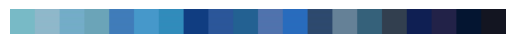

In [105]:
# Directory containing the 20 images
image_directory = f'{charts_images_path}/*.jpg'  # Adjust the path based on your folder structure

image_paths = sorted(glob(image_directory))[:20]  # Load the first 20 images

# Load images
images = [cv2.imread(image_path) for image_path in image_paths if cv2.imread(image_path) is not None]

# Check if images were loaded correctly
if len(images) == 0:
    print("No images were loaded. Check the path and file types.")
else:
    # Concatenate images horizontally or vertically based on axis
    def concatenate_images(images, axis=1):
        return np.concatenate(images, axis=axis)

    # Concatenate the images
    concatenated_image = concatenate_images(images, axis=1)

    # Save the concatenated image
    cv2.imwrite('concatenated_image.png', concatenated_image)

    # Display the concatenated image (Note: cv2.imshow does not work in Colab)
    from matplotlib import pyplot as plt

    plt.imshow(cv2.cvtColor(concatenated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# LAB

## Plot chart

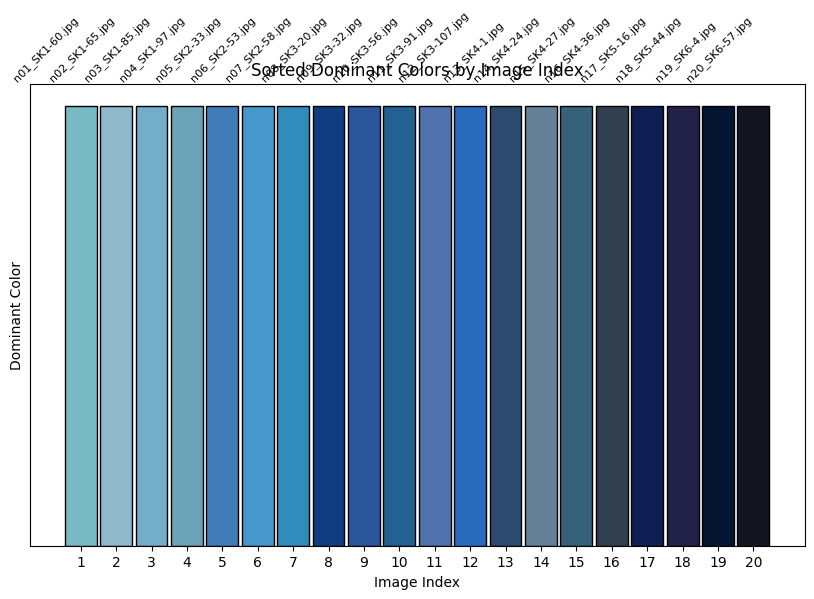

In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from glob import glob

# Function to extract the numeric part from the filename for sorting
def extract_number(filename):
    base_name = os.path.basename(filename)
    number_str = base_name.split('_')[0][1:]  # Get the number part after 'n'
    return int(number_str)

# Function to get the dominant color of an image
def get_dominant_color(image, n_colors=1):
    """Get the dominant color of an image using K-means clustering."""
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(pixels)
    dominant_color = kmeans.cluster_centers_[0].astype(int)
    return dominant_color

# Function to load and sort images based on filenames
def load_and_sort_images(directory_path, n_images):
    """Load images from the directory sorted by their filenames."""
    file_pattern = os.path.join(directory_path, 'n*.jpg')
    file_paths = sorted(glob(file_pattern), key=extract_number)
    images = []
    for file_path in file_paths[:n_images]:
        image = cv2.imread(file_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
        else:
            print(f"Warning: Unable to read image at {file_path}. Skipping...")

    if len(images) < n_images:
        print(f"Warning: Only {len(images)} images found. Adjusting n_images to match available images.")

    return images, file_paths[:n_images]

# Load and sort images based on filenames
directory_path = f'{charts_images_path}/'
images, file_names = load_and_sort_images(directory_path, 20)

# Adjust n_colors if fewer images are available
n_colors = min(20, len(images))

# Quantize the images using K-means clustering
def quantize_images(images, n_colors=1):
    """Quantize a list of images to reduce the number of colors using K-means clustering."""
    kmeans_models = []
    for image in images:
        pixels = image.reshape(-1, 3)
        kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(pixels)
        kmeans_models.append(kmeans)

    return kmeans_models

# Quantize the images
kmeans_models = quantize_images(images, n_colors=1)  # n_colors=1 for dominant color

# Extract dominant colors for each quantized image
dominant_colors = [kmeans.cluster_centers_[0].astype(int) for kmeans in kmeans_models]
# Function to display the histogram with the matched color highlighted
def plot_color_histogram(dominant_colors, file_names, matched_index=None):
    """Plot the histogram of the dominant colors based on image indices."""
    plt.figure(figsize=(10, 6))

    for i, color in enumerate(dominant_colors):
        bar_color = np.array(color) / 255.0
        edge_color = 'red' if (matched_index is not None and i + 1 == matched_index) else 'black'
        plt.bar(i + 1, 1, color=bar_color, edgecolor=edge_color, width=0.9)
        plt.text(i + 1, 1.05, file_names[i], rotation=45, ha='right', va='bottom', fontsize=8)

    plt.title("Sorted Dominant Colors by Image Index")
    plt.xlabel("Image Index")
    plt.ylabel("Dominant Color")
    plt.xticks(range(1, len(dominant_colors) + 1))
    plt.yticks([])  # Remove y-axis ticks as they are not relevant
    plt.show()

# Plot the histogram of sorted dominant colors with the matched index highlighted if found
plot_color_histogram(dominant_colors, [os.path.basename(name) for name in file_names], matched_index)

## Prediction

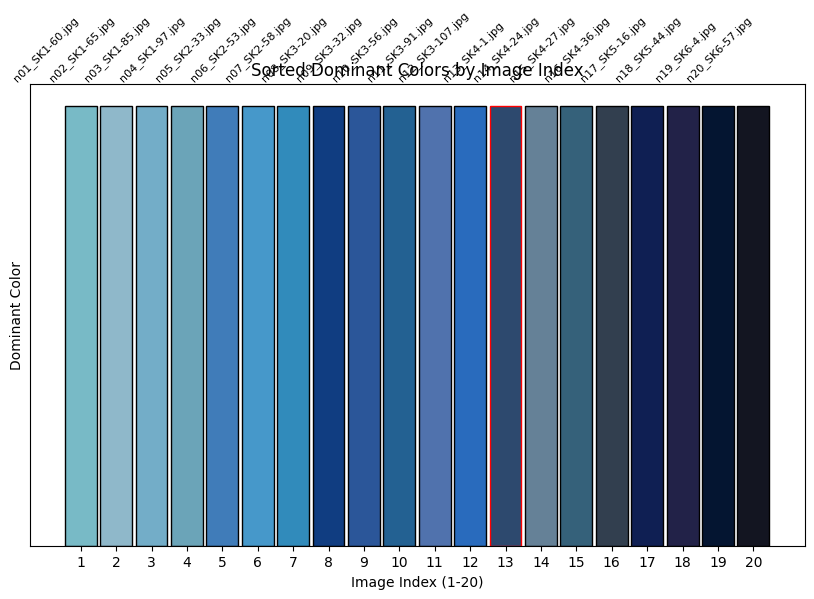

The nearest color index to the original image is 13.


In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from glob import glob


# Function to extract the numeric part from the filename for sorting
def extract_number(filename):
    base_name = os.path.basename(filename)
    number_str = base_name.split('_')[0][1:]  # Get the number part after 'n'
    return int(number_str)

# Function to get the dominant color of an image
def get_dominant_color(image, n_colors=1):
    """Get the dominant color of an image using K-means clustering."""
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(pixels)
    dominant_color = kmeans.cluster_centers_[0].astype(int)
    return dominant_color

# Function to load and sort images based on filenames
def load_and_sort_images(directory_path, n_images):
    """Load images from the directory sorted by their filenames."""
    file_pattern = os.path.join(directory_path, 'n*.jpg')
    file_paths = sorted(glob(file_pattern), key=extract_number)
    images = []
    for file_path in file_paths[:n_images]:
        image = cv2.imread(file_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
        else:
            print(f"Warning: Unable to read image at {file_path}. Skipping...")

    if len(images) < n_images:
        print(f"Warning: Only {len(images)} images found. Adjusting n_images to match available images.")

    return images, file_paths[:n_images]

# Load and sort images based on filenames
directory_path = f'{charts_images_path}/'
images, file_names = load_and_sort_images(directory_path, 20)

# Quantize the images using K-means clustering
def quantize_images(images, n_colors=1):
    """Quantize a list of images to reduce the number of colors using K-means clustering."""
    kmeans_models = []
    for image in images:
        pixels = image.reshape(-1, 3)
        kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(pixels)
        kmeans_models.append(kmeans)

    return kmeans_models

# Quantize the images
kmeans_models = quantize_images(images, n_colors=1)  # n_colors=1 for dominant color

# Extract dominant colors for each quantized image
dominant_colors = [kmeans.cluster_centers_[0].astype(int) for kmeans in kmeans_models]

# Load the original image (adjust the path accordingly)
# image_path = '/content/drive/MyDrive/src/chart_colors/OrgImg2.jpg'
# image_path = 'https://raw.githubusercontent.com/billowdev/get-dominant-color/refs/heads/main/OrgImg2.jpg'


# URL of the image
image_url = 'https://raw.githubusercontent.com/billowdev/get-dominant-color/refs/heads/main/OrgImg2.jpg'

# Download the image using requests
response = requests.get(image_url)
image_data = BytesIO(response.content)

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Get the dominant color of the original image
original_image_dominant_color = get_dominant_color(original_image)

# Find the closest matching dominant color in the sorted images
def find_nearest_color_index(target_color, colors):
    """Find the index of the nearest color using Euclidean distance."""
    min_distance = float('inf')
    nearest_index = None
    for i, color in enumerate(colors):
        distance = np.linalg.norm(target_color - color)
        if distance < min_distance:
            min_distance = distance
            nearest_index = i
    return nearest_index + 1  # Return 1-based index

# Find the nearest color index
nearest_index = find_nearest_color_index(original_image_dominant_color, dominant_colors)

# Function to plot the histogram of sorted dominant colors
def plot_color_histogram(dominant_colors, file_names, nearest_index=None):
    """Plot the histogram of the dominant colors based on image indices."""
    plt.figure(figsize=(10, 6))

    for i, color in enumerate(dominant_colors):
        bar_color = np.array(color) / 255.0
        edge_color = 'red' if (nearest_index is not None and i + 1 == nearest_index) else 'black'
        plt.bar(i + 1, 1, color=bar_color, edgecolor=edge_color, width=0.9)
        plt.text(i + 1, 1.05, file_names[i], rotation=45, ha='right', va='bottom', fontsize=8)

    plt.title("Sorted Dominant Colors by Image Index")
    plt.xlabel("Image Index (1-20)")
    plt.ylabel("Dominant Color")
    plt.xticks(range(1, len(dominant_colors) + 1))
    plt.yticks([])  # Remove y-axis ticks as they are not relevant
    plt.show()

# Plot the histogram of sorted dominant colors with the nearest index highlighted
plot_color_histogram(dominant_colors, [os.path.basename(name) for name in file_names], nearest_index)

# Output the result of the nearest match
print(f"The nearest color index to the original image is {nearest_index}.")


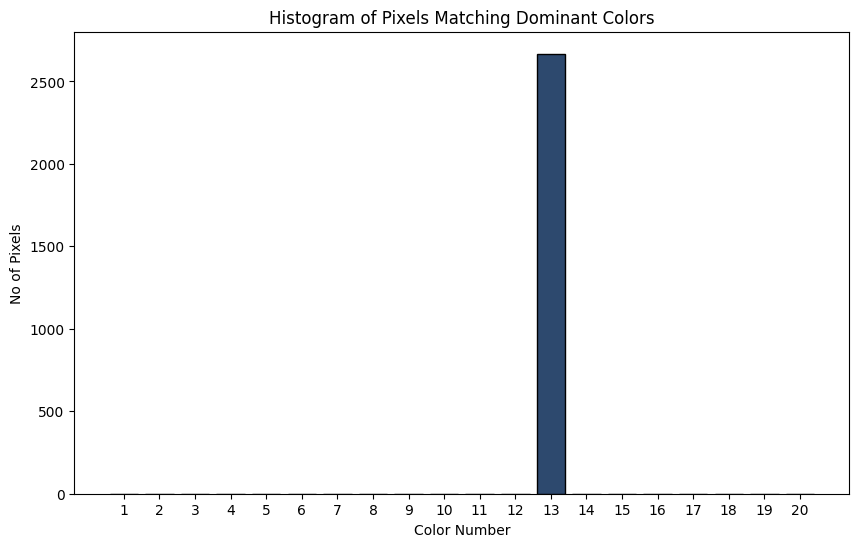

In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from glob import glob
import requests
from io import BytesIO

# Function to calculate the number of pixels in the image that match a given color
def count_pixels_matching_color(image, color, threshold=20):
    """Count the number of pixels in the image that match the given color within a threshold."""
    pixels = image.reshape(-1, 3)
    distances = np.linalg.norm(pixels - color, axis=1)
    count = np.sum(distances <= threshold)
    return count

# Plot the histogram based on the pixel counts
def plot_pixel_histogram(pixel_counts):
    """Plot the histogram of pixel counts for each dominant color."""
    plt.figure(figsize=(10, 6))
    # Set up bars with the color corresponding to each dominant color
    for i, (count, color) in enumerate(zip(pixel_counts, dominant_colors)):
        bar_color = np.array(color) / 255.0  # Convert RGB to normalized values for matplotlib
        plt.bar(i + 1, count, color=bar_color, edgecolor='black', width=0.8)

    plt.title("Histogram of Pixels Matching Dominant Colors")
    plt.xlabel("Color Number")
    plt.ylabel("No of Pixels")
    plt.xticks(range(1, len(pixel_counts) + 1))
    plt.show()


# Load the original image (adjust the path accordingly)
image_path = 'https://raw.githubusercontent.com/billowdev/get-dominant-color/refs/heads/main/OrgImg2.jpg'

# Download the image using requests
response = requests.get(image_url)
image_data = BytesIO(response.content)

# Read the image with OpenCV
original_image = cv2.imdecode(np.frombuffer(image_data.read(), np.uint8), cv2.IMREAD_COLOR)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Calculate the number of pixels in the original image that match each dominant color
pixel_counts = [count_pixels_matching_color(original_image, color) for color in dominant_colors]

# Plot the histogram
plot_pixel_histogram(pixel_counts)


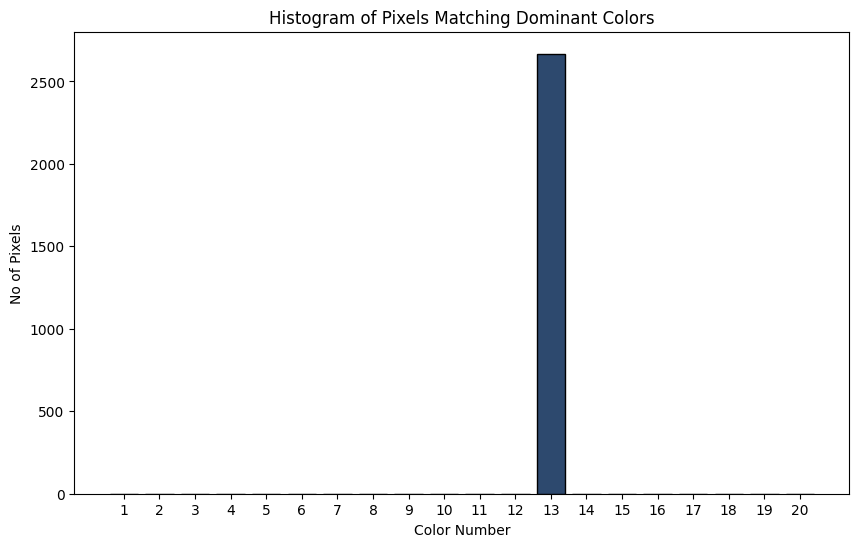

In [118]:

# Load the original image (adjust the path accordingly)
image_path = 'https://raw.githubusercontent.com/billowdev/get-dominant-color/refs/heads/main/test.png'

# Download the image using requests
response = requests.get(image_url)
image_data = BytesIO(response.content)

# Read the image with OpenCV
original_image = cv2.imdecode(np.frombuffer(image_data.read(), np.uint8), cv2.IMREAD_COLOR)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Calculate the number of pixels in the original image that match each dominant color
pixel_counts = [count_pixels_matching_color(original_image, color) for color in dominant_colors]

# Plot the histogram
plot_pixel_histogram(pixel_counts)

### Upload files to test

Saving n02_SK1-65.jpg to n02_SK1-65.jpg


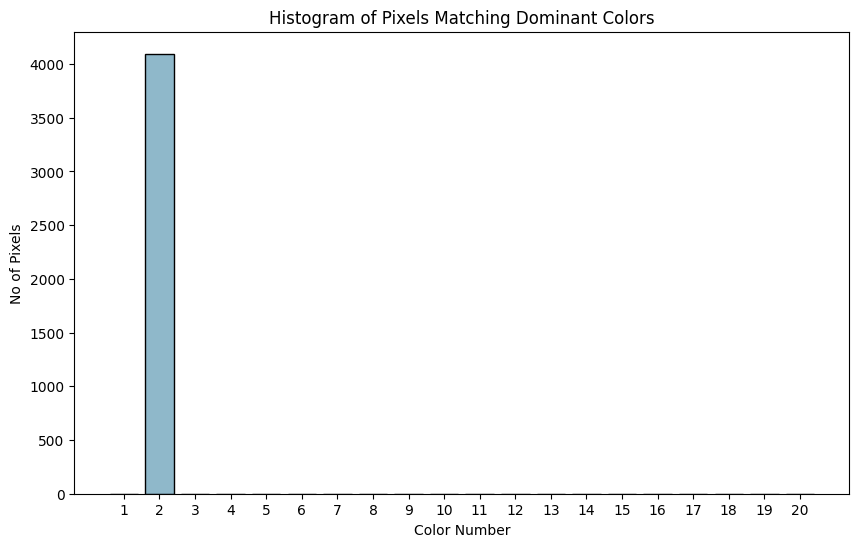

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from glob import glob
from google.colab import files

# Function to calculate the number of pixels in the image that match a given color
def count_pixels_matching_color(image, color, threshold=20):
    """Count the number of pixels in the image that match the given color within a threshold."""
    pixels = image.reshape(-1, 3)
    distances = np.linalg.norm(pixels - color, axis=1)
    count = np.sum(distances <= threshold)
    return count

# Plot the histogram based on the pixel counts
def plot_pixel_histogram(pixel_counts):
    """Plot the histogram of pixel counts for each dominant color."""
    plt.figure(figsize=(10, 6))
    # Set up bars with the color corresponding to each dominant color
    for i, (count, color) in enumerate(zip(pixel_counts, dominant_colors)):
        bar_color = np.array(color) / 255.0  # Convert RGB to normalized values for matplotlib
        plt.bar(i + 1, count, color=bar_color, edgecolor='black', width=0.8)

    plt.title("Histogram of Pixels Matching Dominant Colors")
    plt.xlabel("Color Number")
    plt.ylabel("No of Pixels")
    plt.xticks(range(1, len(pixel_counts) + 1))
    plt.show()


# Load the original image (adjust the path accordingly)
uploaded = files.upload()

# Get the uploaded file path
image_path = next(iter(uploaded.keys()))
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Calculate the number of pixels in the original image that match each dominant color
pixel_counts = [count_pixels_matching_color(original_image, color) for color in dominant_colors]

# Plot the histogram
plot_pixel_histogram(pixel_counts)
